In [ ]:
!pip install tensorflow==2.7.0

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

batch_size = 64

In [ ]:
data_dir="/content/drive/MyDrive/Dataset/skin_patch_edited"

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  # validation_split=0.2,
  # subset="training",
  seed=123,
  shuffle=True,
  class_names=["level_0", "level_1", "level_2"],
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

Found 1579 files belonging to 3 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['level_0', 'level_1', 'level_2']


In [ ]:
# Count number of images in each class
class_count = {}
with tf.device('/gpu:0'):
  for _, labels in train_ds:
    for label in labels:
      label = int(label)
      if label not in class_count:
        class_count[label] = 0
      class_count[label] += 1

  # Calculate class weights
  total_samples = sum(class_count.values())
  class_weight = {}
  for label, count in class_count.items():
    class_weight[label] = total_samples / (len(class_count) * count)

In [ ]:
print(class_count)
print(class_weight)

{1: 575, 2: 418, 0: 586}
{1: 0.9153623188405797, 2: 1.259170653907496, 0: 0.8981797497155859}


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

Found 1579 files belonging to 3 classes.
Using 315 files for validation.


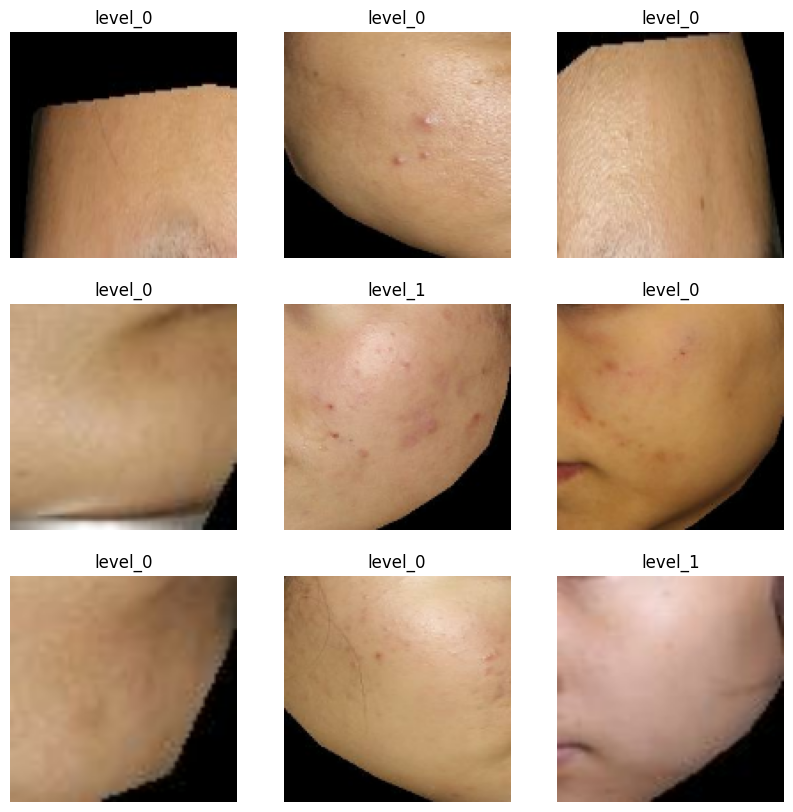

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

##Test Data

In [ ]:
img_filepath_0 = "/content/drive/MyDrive/Detection/VOC2007/ImageSets/Main/NNEW_test_0.txt"
img_filepath_1 = "/content/drive/MyDrive/Detection/VOC2007/ImageSets/Main/NNEW_test_1.txt"
img_filepath_2 = "/content/drive/MyDrive/Detection/VOC2007/ImageSets/Main/NNEW_test_2.txt"
img_filepath_3 = "/content/drive/MyDrive/Detection/VOC2007/ImageSets/Main/NNEW_test_3.txt"

In [ ]:
from tqdm import tqdm

X_test = []
for image in tqdm(img_filename):
    img = cv2.imread(f"{data_path}/{str(image)}")
    resized_image = cv2.resize(img, (256, 256))
    X_test.append(resized_image)

100%|██████████| 1165/1165 [02:15<00:00,  8.57it/s]


In [ ]:
for i in range(2):
  fp = open(f"/content/drive/MyDrive/Detection/VOC2007/ImageSets/Main/NNEW_test_{i}.txt", 'r')

  img_filename = []
  labels = []
  lesions = []
  for line in fp.readlines():
      filename, label, lesion = line.split()
      img_filename.append(filename)
      labels.append(int(label))
      lesions.append(int(lesion))

  fp.close()

In [ ]:
X_test = np.array(X_test)
X_test = X_test/255
y = np.array(labels)
X_test.shape

(1165, 256, 256, 3)

In [ ]:
X_test.shape

(1165, 256, 256, 3)

##VGG 16

---

In [ ]:
VGG_model = VGG16(weights="imagenet", include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# for layer in VGG_model.layers:
#   layer.trainable = False

In [ ]:
def custom_activation(x):
  return tf.keras.activations.relu(x, alpha=0.1, max_value=2, threshold=0.0)

In [ ]:
# input
input = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
# normalisation
normalization_layer = tf.keras.layers.Rescaling(1./255)(input)
# data augmentation
a1 = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(normalization_layer)
a3 = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")(a1)
# VGG 16
out = VGG_model(a3)
x = tf.keras.layers.GlobalMaxPooling2D()(out)

# dense layer
d1 = tf.keras.layers.Dense(256, activation="relu")(x)
d2 = tf.keras.layers.Dense(128, activation="relu")(d1)
d3 = tf.keras.layers.Dense(64, activation="relu")(d2)
prediction = tf.keras.layers.Dense(3, activation="softmax")(d3)

model = tf.keras.Model(inputs=input, outputs=prediction)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, learning_rate):
    if epoch < 10:
        return learning_rate
    else:
        return learning_rate * 0.1

adam = Adam(learning_rate=0.001)
lr_callback = LearningRateScheduler(lr_scheduler)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 random_rotation_5 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 random_flip_5 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                  

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Acne_Classifyer_VGG.h5", verbose=1, save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=5),
    lr_callback
    ]

In [ ]:
model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
with tf.device('/gpu:0'):
  H = model.fit(train_ds, validation_data=val_ds, epochs=64, callbacks=callbacks, class_weight=class_weight)

Epoch 1/64
67/67 [==============================] - ETA: 0s - loss: 1.2117 - accuracy: 0.3089
Epoch 00001: val_loss improved from inf to 1.13617, saving model to Acne_Classifyer_VGG.h5
67/67 [==============================] - 13s 163ms/step - loss: 1.2117 - accuracy: 0.3089 - val_loss: 1.1362 - val_accuracy: 0.3970 - lr: 0.0010
Epoch 2/64
67/67 [==============================] - ETA: 0s - loss: 1.1046 - accuracy: 0.3290
Epoch 00002: val_loss did not improve from 1.13617
67/67 [==============================] - 12s 174ms/step - loss: 1.1046 - accuracy: 0.3290 - val_loss: 1.1381 - val_accuracy: 0.1685 - lr: 0.0010
Epoch 3/64
67/67 [==============================] - ETA: 0s - loss: 1.1071 - accuracy: 0.3710
Epoch 00003: val_loss improved from 1.13617 to 1.10572, saving model to Acne_Classifyer_VGG.h5
67/67 [==============================] - 11s 163ms/step - loss: 1.1071 - accuracy: 0.3710 - val_loss: 1.1057 - val_accuracy: 0.3970 - lr: 0.0010
Epoch 4/64
67/67 [============================

KeyboardInterrupt: ignored

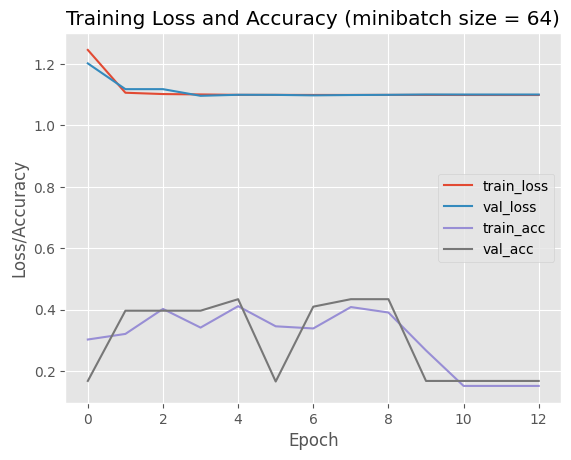

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 13), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 13), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 13), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 13), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (minibatch size = 64)")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# Make predictions on validation dataset
y_pred = model.predict(val_ds)
y_pred_classes = np.rint(y_pred)
print(y_pred)
# Get true class labels from validation dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)
print(y_true)
# y_true_classes = np.argmax(y_true, axis=0)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

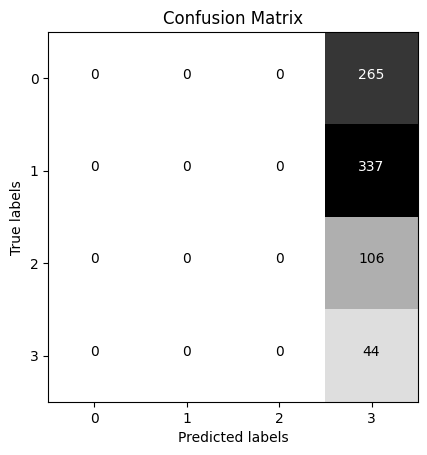

In [ ]:
# Visualize the confusion matrix
plt.imshow(cm, cmap='binary')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Add tick marks for each label
tick_marks = np.arange(len(np.unique(y_true)))
plt.xticks(tick_marks, np.unique(y_true))
plt.yticks(tick_marks, np.unique(y_true))

# Add labels for each cell
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print("Accuracy", acc)

4/4 [==============================] - 5s 787ms/step - loss: 1.1187 - accuracy: 0.4359
Accuracy 0.43589743971824646


##Resnet 101

---

In [ ]:
resnet101 = tf.keras.applications.ResNet101(include_top=False, weights="imagenet")

171446536/171446536 [==============================] - 1s 0us/step


In [ ]:
# for layer in resnet101.layers:
#   layer.trainable = False
#   if layer.name == "conv3_block1_1_conv":
#     break

In [ ]:
def custom_activation(x):
  return tf.keras.activations.relu(x, alpha=0.1, max_value=2, threshold=0.0)

In [ ]:
input = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

# data augmentation
a1 = tf.keras.layers.experimental.preprocessing.RandomRotation(0.4)(input)
a2 = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")(a1)

# resnet
out = resnet101(a2)
x = tf.keras.layers.GlobalMaxPooling2D()(out)

# dense layer
d1 = tf.keras.layers.Dense(256, activation="relu")(x)
d2 = tf.keras.layers.Dense(128, activation="relu")(d1)
d3 = tf.keras.layers.Dense(64, activation="relu")(d2)
prediction = tf.keras.layers.Dense(3, activation="softmax")(d3)

model = tf.keras.Model(inputs=input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 random_rotation (RandomRota  (None, 128, 128, 3)      0         
 tion)                                                           
                                                                 
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 resnet101 (Functional)      (None, None, None, 2048)  42658176  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, learning_rate):
    if epoch < 8:
        return learning_rate
    else:
        return learning_rate * 0.1

adam = Adam(learning_rate=0.001)
lr_callback = LearningRateScheduler(lr_scheduler)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/models/Acne_Classifyer_N_Resnet_T.h5", verbose=1, save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=6),
    lr_callback
    ]

In [ ]:
model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
with tf.device('/gpu:0'):
  H = model.fit(train_ds, validation_data=val_ds, epochs=64, callbacks=callbacks, class_weight=class_weight)

Epoch 1/64
25/25 [==============================] - ETA: 0s - loss: 2.0398 - accuracy: 0.3781
Epoch 1: val_loss improved from inf to 274036.53125, saving model to /content/drive/MyDrive/models/Acne_Classifyer_N_Resnet_T.h5
25/25 [==============================] - 123s 1s/step - loss: 2.0398 - accuracy: 0.3781 - val_loss: 274036.5312 - val_accuracy: 0.2603 - lr: 0.0010
Epoch 2/64
25/25 [==============================] - ETA: 0s - loss: 1.2141 - accuracy: 0.4338
Epoch 2: val_loss improved from 274036.53125 to 3188.81885, saving model to /content/drive/MyDrive/models/Acne_Classifyer_N_Resnet_T.h5
25/25 [==============================] - 14s 551ms/step - loss: 1.2141 - accuracy: 0.4338 - val_loss: 3188.8188 - val_accuracy: 0.2603 - lr: 0.0010
Epoch 3/64
25/25 [==============================] - ETA: 0s - loss: 1.0890 - accuracy: 0.4535
Epoch 3: val_loss improved from 3188.81885 to 246.09239, saving model to /content/drive/MyDrive/models/Acne_Classifyer_N_Resnet_T.h5
25/25 [=================

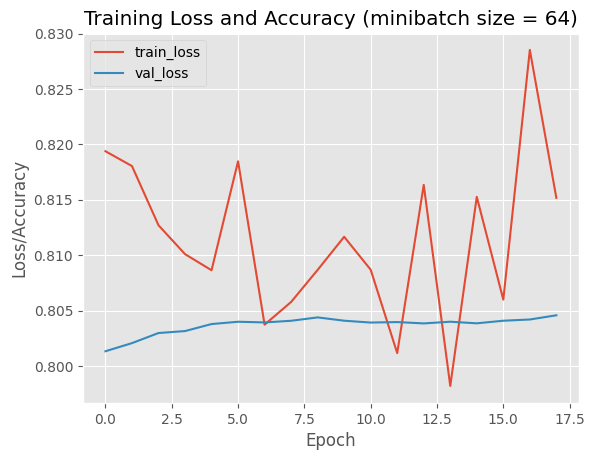

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 18), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 18), H.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, 24), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, 24), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (minibatch size = 64)")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()

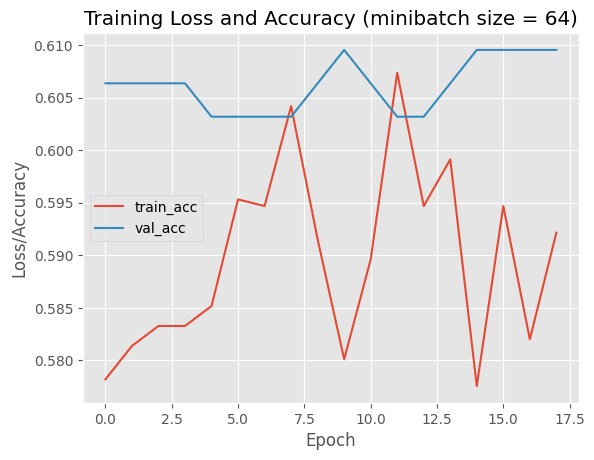

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, 24), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, 24), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 18), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 18), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (minibatch size = 64)")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
def load_trained_model(weights_path):
  model.load_weights(weights_path)
  return model

In [ ]:
model = load_trained_model("/content/drive/MyDrive/models/Acne_Classifyer_N_Resnet_T.h5")

In [ ]:
loss, acc = model.evaluate(val_ds)
print("Accuracy", acc)

5/5 [==============================] - 1s 110ms/step - loss: 0.8522 - accuracy: 0.5778
Accuracy 0.5777778029441833


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# Make predictions on validation dataset
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# print(set(y_pred_classes.reshape(-1)))
# Get true class labels from validation dataset

y_true = np.concatenate([y for x, y in val_ds], axis=0)

# print(set(y_true.tolist()))
# y_true_classes = np.argmax(y_true, axis=0)
# Compute confusion matrix

cm = confusion_matrix(y_true, y_pred_classes)

5/5 [==============================] - 3s 121ms/step


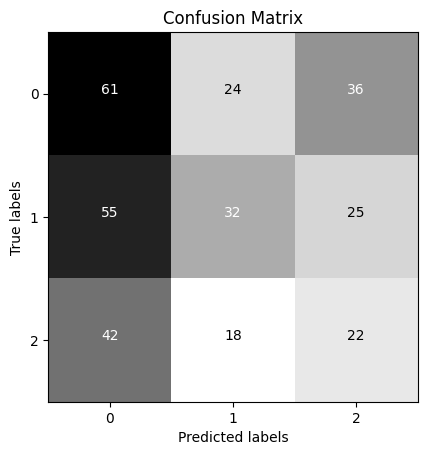

In [ ]:
# Visualize the confusion matrix
plt.imshow(cm, cmap='binary')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Add tick marks for each label
tick_marks = np.arange(len(np.unique(y_true)))
plt.xticks(tick_marks, np.unique(y_true))
plt.yticks(tick_marks, np.unique(y_true))

# Add labels for each cell
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

##U net

---

In [ ]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

# building model
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
d_a = data_augmentation(inputs)
c1 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(d_a)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)


c3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

o = tf.keras.layers.Conv2D(4, (1, 1), activation='softmax')(c5)

x = tf.keras.layers.GlobalAveragePooling2D()(o)

f = tf.keras.layers.Flatten()(x)
d1 = tf.keras.layers.Dense(128, activation="relu")(f)
d2 = tf.keras.layers.Dense(64, activation="relu")(d1)
outputs = tf.keras.layers.Dense(3, activation="softmax")(d2)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, learning_rate):
    if epoch < 10:
        return learning_rate
    else:
        return learning_rate * 0.1

adam = Adam(learning_rate=0.001)
lr_callback = LearningRateScheduler(lr_scheduler)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Acne_Classifyer_U_net.h5", verbose=1, save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=8),
    lr_callback
    ]

In [ ]:
model.compile(optimizer=adam, loss="mse", metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                           

In [ ]:
with tf.device('/gpu:0'):
  H = model.fit(train_ds, validation_data=val_ds, epochs=64, callbacks=callbacks, class_weight=class_weight)

Epoch 1/64
25/25 [==============================] - ETA: 0s - loss: 1.1113 - accuracy: 0.3661
Epoch 1: val_loss improved from inf to 0.92384, saving model to Acne_Classifyer_U_net.h5
25/25 [==============================] - 14s 186ms/step - loss: 1.1113 - accuracy: 0.3661 - val_loss: 0.9238 - val_accuracy: 0.2603 - lr: 0.0010
Epoch 2/64
24/25 [===========================>..] - ETA: 0s - loss: 1.1137 - accuracy: 0.3158
Epoch 2: val_loss improved from 0.92384 to 0.92381, saving model to Acne_Classifyer_U_net.h5
25/25 [==============================] - 3s 104ms/step - loss: 1.1111 - accuracy: 0.3135 - val_loss: 0.9238 - val_accuracy: 0.2603 - lr: 0.0010
Epoch 3/64
24/25 [===========================>..] - ETA: 0s - loss: 1.1185 - accuracy: 0.3066
Epoch 3: val_loss improved from 0.92381 to 0.92381, saving model to Acne_Classifyer_U_net.h5
25/25 [==============================] - 4s 140ms/step - loss: 1.1111 - accuracy: 0.3097 - val_loss: 0.9238 - val_accuracy: 0.3714 - lr: 0.0010
Epoch 4/64

##Loading Weights
---

In [ ]:
load_model = tf.keras.applications.ResNet101(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
load_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          